# Aplicação do modelo de qualidade da água - Acúmulo e Lavagem (Buildup/Washoff)

## Imports

In [52]:
import locale
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt

from matplotlib import rcParams
from matplotlib import rc
from datetime import datetime, timedelta

from plotly.subplots import make_subplots
from plotly.offline import plot
from mogestpy.quality import buwo
from mogestpy.quantity.Hydrological import Muskingum
from spotpy.objectivefunctions import rmse, nashsutcliffe, pbias, kge

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['CMU Serif']
rcParams['text.usetex'] = True

pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [53]:
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter 
month_fmt = DateFormatter('%b')
def m_fmt(x, pos=None):
    return month_fmt(x)[0]

DataFrames com dados

In [54]:
df_Qd = pd.read_excel('esc_direto.xlsx', index_col=0)
df_Qmm = pd.read_excel("Vazao_mm.xlsx", index_col=0)
df_cpontuais = pd.read_excel("cpontuais.xlsx")

In [55]:
df_cpontuais_ton = df_cpontuais.div(1e3)

In [56]:
df_data = pd.read_excel('case.xlsx')

In [57]:
codes = [86492, 86493, 86494, 86495, 86496, 86497, 86498, 86499]

In [58]:
loadgens = []

for i in range(8):
    loadgen = buwo.BuildUpWashoff(landuse_name='',
                                  Bmax=df_data['Bmax'][i],
                                  Nb=df_data['Nb'][i],
                                  Kb=df_data['Kb'][i],
                                  threshold_flow=0.02,
                                  Nw=df_data['Nw'][i],
                                  Kw=df_data['Kw'][i],
                                  BuMethod=2,
                                  WoMethod=1,
                                  timestep_h=24,
                                  initial_buildup=1,
                                  area=df_data['AD'][i],
                                  area_fraction=1,
                                  surface_flow=df_Qd[codes[i]]/df_data['AD'][i]*86.4)
    loadgens.append(loadgen)

In [59]:
for loadgen in loadgens:
    loadgen.Process(verbose=False)

In [60]:
df_Bu = pd.DataFrame()  

for i in range(8):
    df_Bu[codes[i]] = loadgens[i].BuildUp

In [61]:
df_Bu_ton = df_Bu.div(1e3) # conversão para ton

In [62]:
df_ctotais = df_Bu_ton+df_cpontuais_ton

Capacidade de produção de carga (total)

In [63]:
df_Wo = pd.DataFrame()
for i in range(8):
    df_Wo[codes[i]] = loadgens[i].Washoff

In [64]:
df_Qinc = pd.read_excel("vazoes_simuladas.xlsx", index_col=0)

In [65]:
df_WoC = pd.DataFrame()
for i in range(8):
    df_WoC[codes[i]] = df_Wo[codes[i]]/df_Qinc[codes[i]]/86.4

In [66]:
df_total_lavado = df_cpontuais + df_Wo

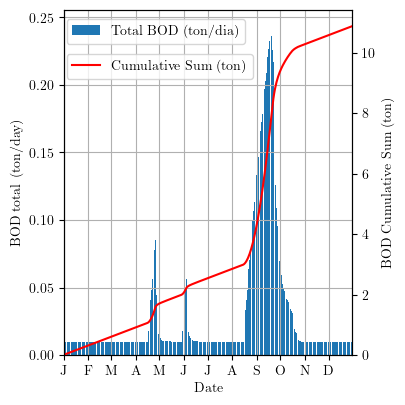

In [110]:
fig, ax = plt.subplots(figsize=(10/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=366, freq='D')

ax.bar(xaxis, (df_ctotais[86494][365:]).values, label= 'Total BOD (ton/dia)')
# plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(xaxis, (df_ctotais[86494][365:]).cumsum().values, color='red', label='Cumulative Sum (ton)')

ax.legend(loc=(.01, .9))
ax2.legend(loc=(.01, .8))
# Set axis titles
ax.grid()
ax.set_xlabel('Date')
ax.set_ylabel('BOD total (ton/day)')
ax2.set_ylabel('BOD Cumulative Sum (ton)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
ax2.set_ylim(0)

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))

# plt.savefig('H:/GitHub/Thesis/images/case2/bu94.pdf')

plt.show()

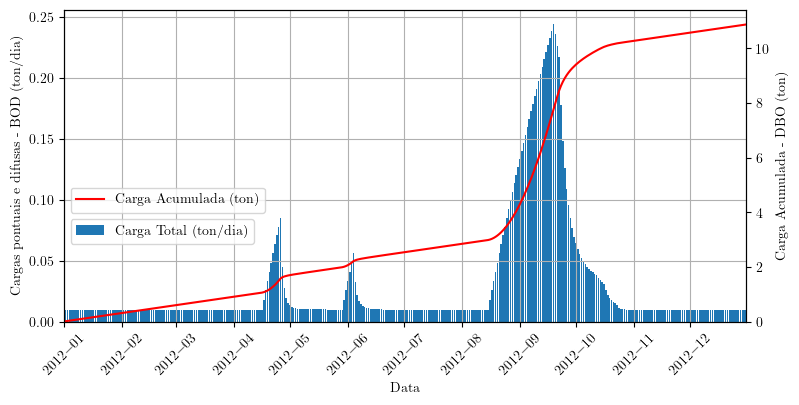

In [103]:
fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=366, freq='D')

ax.bar(xaxis, (df_ctotais[86494][365:]).values, label='Carga Total (ton/dia)')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(xaxis, (df_ctotais[86494][365:]).cumsum().values, color='red', label='Carga Acumulada (ton)')

ax.legend(loc=(.01, .25))
ax2.legend(loc=(.01, .35))
# Set axis titles
ax.grid()
ax.set_xlabel('Data')
ax.set_ylabel('Cargas pontuais e difusas - BOD (ton/dia)')
ax2.set_ylabel('Carga Acumulada - DBO (ton)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
ax2.set_ylim(0)



plt.show()

In [69]:
fig = df_total_lavado[86494].plot()

In [70]:
df_total_lavadoC = df_total_lavado / df_Qinc[codes] / 86.4

In [71]:
concentracao_estrela = df_total_lavadoC[86498]+df_total_lavadoC[86499]

In [72]:
concentracao_estrela[365:]

365    5.122063
366    5.314242
367    5.489511
368    5.650879
369    5.798919
         ...   
726    3.007979
727    2.986308
728    3.007237
729    2.642946
730    2.474555
Length: 366, dtype: float64

In [73]:
def sp_eq(Lo, kd, t):
    return Lo * np.exp(-kd * t)

In [74]:
df2 = pd.read_excel('qual.xlsx', index_col=0)

In [75]:
len(concentracao_estrela[365:].values)

366

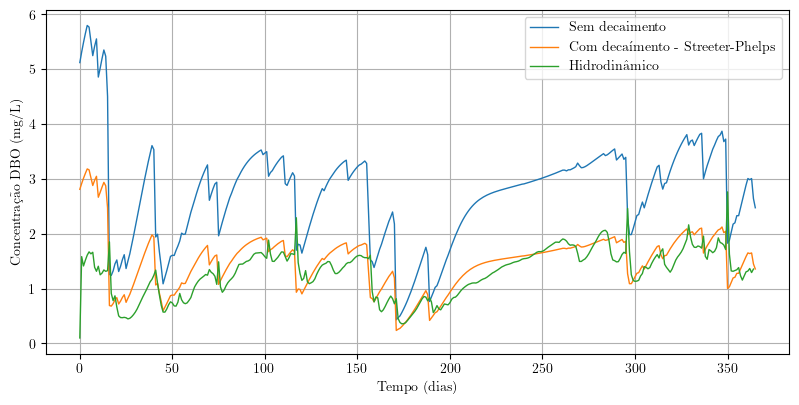

In [76]:
fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

x = [i + 1 for i in range(365)]

ax.set_xlabel('Tempo (dias)')
ax.plot(concentracao_estrela[365:].values, label='Sem decaimento', linewidth=1)
ax.plot(sp_eq(concentracao_estrela[365:].values, .2, 3), label='Com decaímento - Streeter-Phelps', linewidth=1)
ax.plot(df2['c_sim'].values, label='Hidrodinâmico', linewidth=1)
ax.set_ylabel('Concentração DBO (mg/L)')
ax.legend()
ax.grid(True)

plt.show()


C:\Users\Dario\AppData\Local\Temp\ipykernel_23404\786257680.py:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



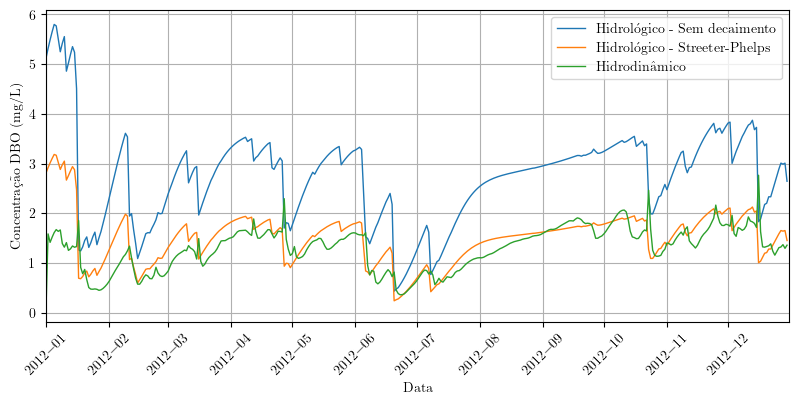

In [77]:
fig, ax = plt.subplots(figsize=(20/2.54, 10/2.54), constrained_layout=True)

start_date = datetime(2012, 1, 1)
end_date = start_date + timedelta(days=365)
x = [start_date + timedelta(days=i) for i in range(365)]

y1 = concentracao_estrela[365:].values[:-1]
y2 = sp_eq(concentracao_estrela[365:].values[:-1], .2, 3)
y3 = df2['c_sim'].values[:]

ax.set_xlabel('Data')
ax.plot(x, y1, label='Hidrológico - Sem decaimento', linewidth=1)
ax.plot(x, y2, label='Hidrológico - Streeter-Phelps', linewidth=1)
ax.plot(x, y3, label='Hidrodinâmico', linewidth=1)
ax.set_ylabel('Concentração DBO (mg/L)')
ax.grid(True)
ax.set_xlim(start_date, end_date)

ax.legend()

# Rotate x-axis ticks by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()
ax.grid(True)

ax.set_xlim(start_date, end_date)

plt.show()

In [78]:
trace1 = go.Scatter(x=x, y=concentracao_estrela[365:].values, name='Sem decaimento')
trace2 = go.Scatter(x=x, y=sp_eq(concentracao_estrela[365:].values, .2, 3), name='Com decaímento - Streeter-Phelps')
trace3 = go.Scatter(x=x, y=df2['c_sim'].values, name='Hidrodinâmico - Simulação anterior')

layout = go.Layout(
    title='Concentração DBO ao longo do tempo',
    xaxis=dict(title='Tempo (dias)'),
    yaxis=dict(title='Concentração DBO (mg/L)'),
    legend=dict(x=.5, y=1),
    font=dict(family='CMU Serif'),
    width=800,
    height=600
)


fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()


Estações somadas até o ponto de Jurumirim

In [79]:
cursos = ['Principal', 86496, 86494, 86493, 86492]

In [80]:
df_Q = pd.DataFrame()
df_Q['Principal'] = df_Qinc[86499] + df_Qinc[86498] + df_Qinc[86497] +  df_Qinc[86495]
df_Q[86496] = df_Qinc[86496]
df_Q[86494] = df_Qinc[86494]
df_Q[86493] = df_Qinc[86493]
df_Q[86492] = df_Qinc[86492]

In [81]:
df_W = pd.DataFrame()
df_W['Principal'] =df_total_lavado[86499] +df_total_lavado[86498] + df_total_lavado[86497] +  df_total_lavado[86495]
df_W[86496] = df_total_lavado[86496]
df_W[86494] = df_total_lavado[86494]
df_W[86493] = df_total_lavado[86493]
df_W[86492] = df_total_lavado[86492]

In [82]:
for curso in cursos:
    df_Q[curso] = Muskingum.Muskingum.downstream_routing(df_Q[curso], 1.6, .25, 1)

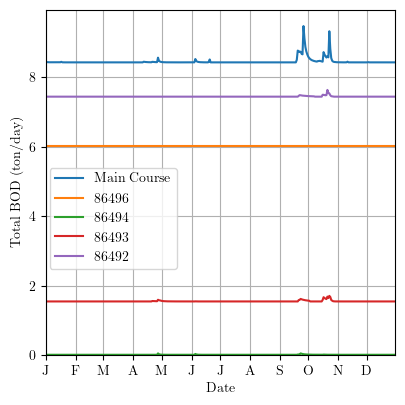

In [111]:
fig, ax = plt.subplots(figsize=(10/2.54, 10/2.54), constrained_layout=True)

xaxis = pd.date_range(start='2012-01-01', periods=366, freq='D')

# Graph for Sub-bacia 86496
ax.plot(xaxis, (df_W['Principal'][365:]/1e3).values, label='Main Course')
ax.plot(xaxis, (df_W[86496][365:]/1e3).values, label='86496')
ax.plot(xaxis, (df_W[86494][365:]/1e3).values, label='86494')
ax.plot(xaxis, (df_W[86493][365:]/1e3).values, label='86493')
ax.plot(xaxis, (df_W[86492][365:]/1e3).values, label='86492')

ax.legend(loc=(.01, .25))

# Set axis titles
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Total BOD (ton/day)')

ax.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax.set_ylim(0)
# plt.xticks(rotation=45)
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
# plt.savefig('H:/GitHub/Thesis/images/case2/W.pdf')

plt.show()

In [84]:
df_Wc = pd.DataFrame()
df_Wc['Principal'] = df_W['Principal']/df_Q['Principal']/86.4
df_Wc[86496] = df_W[86496]/df_Q[86496]/86.4
df_Wc[86494] = df_W[86494]/df_Q[86494]/86.4
df_Wc[86493] = df_W[86493]/df_Q[86493]/86.4
df_Wc[86492] = df_W[86492]/df_Q[86492]/86.4

In [85]:
df_Wc

,Principal,86496,86494,86493,86492
0,inf,inf,inf,inf,inf
1,inf,inf,inf,inf,8.597954e+04
2,1469.341081,inf,1.552391,821.721747,8.311379e+03
3,100.670239,1160.851258,0.151621,70.005739,6.355921e+03
4,24.858665,112.213054,0.059347,27.971379,9.632061e+02
...,...,...,...,...,...
726,1.620512,1.671059,0.004391,0.616574,8.385464e-01
727,1.698072,1.689241,0.004674,0.623604,8.070588e-01
728,1.705975,1.698032,0.004799,0.546339,6.730777e-01
729,1.524813,1.733081,0.004012,0.469058,6.272560e-01


In [86]:
total_reservatorio = df_Wc['Principal'] + df_Wc[86496] + df_Wc[86494] + df_Wc[86493] + df_Wc[86492]

In [87]:
total_reservatorio[365:].plot()

In [88]:
total_reservatorio_decaido = sp_eq(total_reservatorio, .2, 4)

In [89]:
total_reservatorio_decaido[365:].plot()

In [90]:
from mogestpy.quality import zero_d
from mogestpy.quantity.Hydrological import MassBalance

In [91]:
df_res = pd.read_excel('0d.xlsx', index_col=0)

In [92]:
df_res['Qinsim'] = (df_Q['Principal'].values + df_Q[86496].values + df_Q[86494].values + df_Q[86493].values + df_Q[86492].values)

In [93]:
df_res['Cin'] = total_reservatorio_decaido.values

In [94]:
y1 = df_res['Qindado'].values
y2 = df_res['Qinsim'].values

In [95]:
import plotly.graph_objs as go

trace1 = go.Scatter(x=x, y=y1, name='Qindado')
trace2 = go.Scatter(x=x, y=y2, name='Qinsim')

layout = go.Layout(
    title='Comparison of Qindado and Qinsim',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Flow'),
    legend=dict(x=.5, y=1),
    font=dict(family='CMU Serif'),
    width=800,
    height=600
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


In [96]:
k = 1e-7
v = 1.15e-7
k_list = [k for i in range(366+365)]
v_list = [v for i in range(366+365)]

In [97]:
slicer = 180

In [98]:
zero_d_sim = zero_d.ZeroDimensional(df_res['Vdado'][slicer:], df_res['Qinsim'][slicer:], df_res['Qout'][slicer:], df_res['Cin'][slicer:],
                                    df_res['As'][slicer:], k_list[slicer:], v_list[slicer:], 86400)

In [99]:
zero_d_sim.RunModel()

In [100]:
res_Jurumirim = zero_d_sim.Output.ConcentrationOut

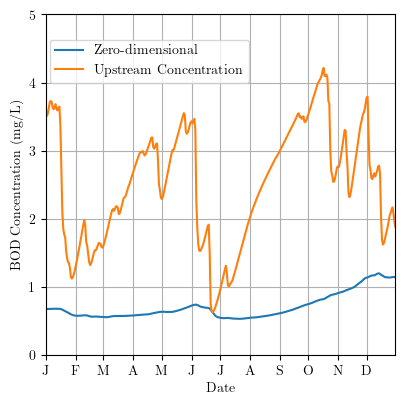

In [109]:
fig, ax = plt.subplots(figsize=(10/2.54, 10/2.54), constrained_layout=True)
xaxis = pd.date_range(start='2011-01-01', periods=731, freq='D')

ax.plot(xaxis[180:], res_Jurumirim, label = 'Zero-dimensional')
ax.plot(xaxis[180:], total_reservatorio_decaido[180:], label = 'Upstream Concentration')
# ax.plot(xaxis[180:], total_reservatorio[180:], label = 'Buildup-Washoff')

ax.set_xlabel('Date')
ax.set_ylabel('BOD Concentration (mg/L)')
ax.set_ylim(0, 5)
ax.set_xlim(xaxis[365], xaxis[-1])
ax.grid(True)
ax.legend(loc=(0.01, .8))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(FuncFormatter(m_fmt))
# plt.savefig('H:/GitHub/Thesis/images/case2/0d.pdf')
plt.show()
